Images uploaded and loaded in order: ['set_4/i1', 'set_4/i2', 'set_4/i3', 'set_4/i4', 'set_4/i5', 'set_4/i6']
Matches set_4/i1 <-> set_4/i2: 23
Matches set_4/i2 <-> set_4/i3: 96
Matches set_4/i3 <-> set_4/i4: 65
Matches set_4/i4 <-> set_4/i5: 45
Matches set_4/i5 <-> set_4/i6: 61


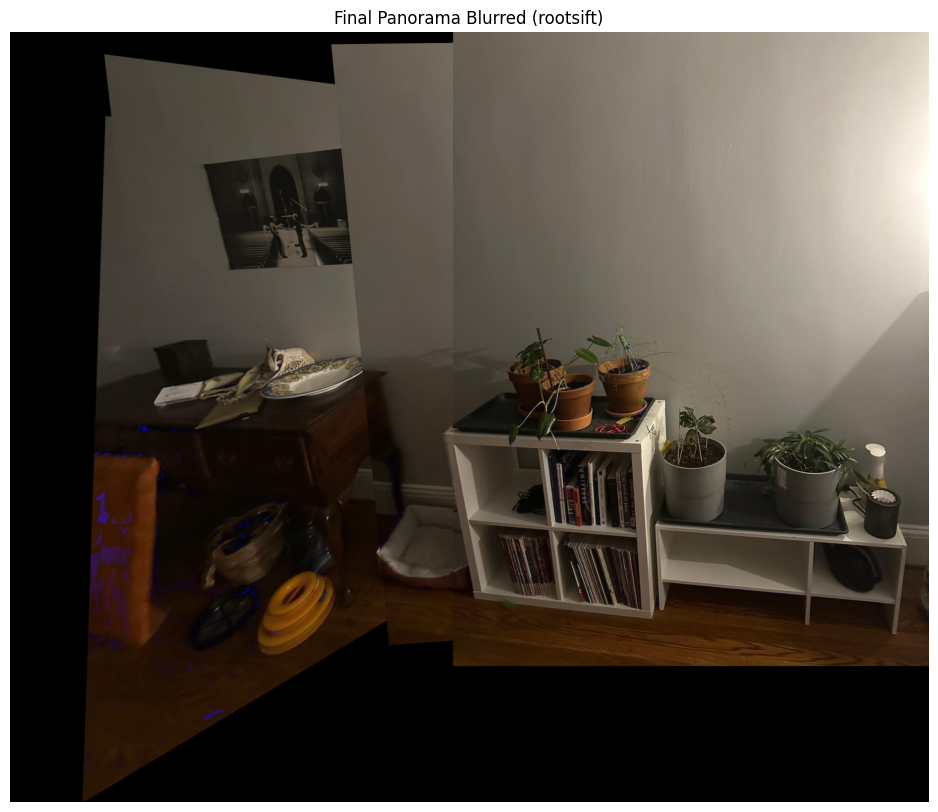

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import io

#uploaded = ["set_4_blurred/i1.jpeg", "set_4_blurred/i2.jpeg", "set_4_blurred/i3.jpeg", "set_4_blurred/i4.jpeg", "set_4_blurred/i5.jpeg", "set_4_blurred/i6.jpeg"]
uploaded = ["set_4/i1.jpeg", "set_4/i2.jpeg", "set_4/i3.jpeg", "set_4/i4.jpeg", "set_4/i5.jpeg", "set_4/i6.jpeg"]
image_paths = natsorted(list(uploaded))
images = [cv2.imread(p, cv2.IMREAD_COLOR)
          for p in image_paths]
names = [p.split('.')[0] for p in image_paths]

print("Images uploaded and loaded in order:", names)
METHOD = "rootsift"   #other options (sift, rootsift, lp_sift, sift_daisy, sift_phog, phase_congruency)

from featurealgos.unified_features import (
    extract_rootsift_features,
    extract_lp_sift_features,
    extract_sift_daisy_features,
    extract_sift_phog_features,
    extract_phase_congruency_sift_features
)

def extract_method(img_gray, method):
    m = method.lower()
    if m == "sift":
        sift = cv2.SIFT_create()
        return sift.detectAndCompute(img_gray, None)
    elif m == "rootsift":
        return extract_rootsift_features(img_gray)
    elif m == "lp_sift":
        return extract_lp_sift_features(img_gray)
    elif m == "sift_daisy":
        return extract_sift_daisy_features(img_gray)
    elif m == "sift_phog":
        return extract_sift_phog_features(img_gray)
    elif m == "phase_congruency":
        return extract_phase_congruency_sift_features(img_gray)
    else:
        raise ValueError(f"Unknown method: {method}")

def match_descriptors(desc1, desc2, ratio=0.75):
    if desc1 is None or desc2 is None:
        return []
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=60)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    knn = matcher.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in knn:
        if m.distance < ratio * n.distance:
            good.append((m.queryIdx, m.trainIdx, m.distance))

    return good

# homogrpahy
def matches_to_points(kp1, kp2, matches):
    pts = []
    for qIdx, tIdx, _ in matches:
        pts.append([
            kp1[qIdx].pt[0], kp1[qIdx].pt[1],
            kp2[tIdx].pt[0], kp2[tIdx].pt[1]
        ])
    return np.array(pts, dtype=np.float64)

def ransac_homography(kp1, kp2, matches, threshold=4.0):
    if len(matches) < 4:
        return None
    pts = matches_to_points(kp1, kp2, matches)
    H, mask = cv2.findHomography(
        pts[:, 0:2], pts[:, 2:4],
        cv2.RANSAC, threshold
    )
    return H

def warp_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners1 = np.float32([[0,0],[w1,0],[w1,h1],[0,h1]]).reshape(-1,1,2)
    corners2 = np.float32([[0,0],[w2,0],[w2,h2],[0,h2]]).reshape(-1,1,2)
    warped_corners1 = cv2.perspectiveTransform(corners1, H)
    all_corners = np.concatenate((warped_corners1, corners2), axis=0)
    x_min, y_min = np.int32(all_corners.min(axis=0).ravel())
    x_max, y_max = np.int32(all_corners.max(axis=0).ravel())
    trans = np.array([[1,0,-x_min],[0,1,-y_min],[0,0,1]], dtype=np.float64)
    size = (x_max - x_min, y_max - y_min)
    result1 = cv2.warpPerspective(img1, trans @ H, size)
    result2 = cv2.warpPerspective(img2, trans, size)
    mask = (result2 > 0)
    result1[mask] = result2[mask]
    return result1

panorama = images[0]
gray = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
kp_pano, desc_pano = extract_method(gray, METHOD)

for i in range(1, len(images)):
    img_next = images[i]
    gray_next = cv2.cvtColor(img_next, cv2.COLOR_BGR2GRAY)
    kp_next, desc_next = extract_method(gray_next, METHOD)
    matches = match_descriptors(desc_pano, desc_next)
    print(f"Matches {names[i-1]} <-> {names[i]}: {len(matches)}")
    H = ransac_homography(kp_pano, kp_next, matches)
    if H is None:
        print(f"Skipping {names[i]}, not enough matches")
        continue
    panorama = warp_images(panorama, img_next, H)
    gray_pan = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    kp_pano, desc_pano = extract_method(gray_pan, METHOD)

panorama_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(panorama_rgb)
plt.axis('off')
plt.title(f"Final Panorama Blurred ({METHOD})")
plt.show()


Images uploaded and loaded in order: ['set_4/i1', 'set_4/i2', 'set_4/i3', 'set_4/i4', 'set_4/i5', 'set_4/i6']
Matches set_4/i1 <-> set_4/i2: 103
Matches set_4/i2 <-> set_4/i3: 48
Matches set_4/i3 <-> set_4/i4: 143
Matches set_4/i4 <-> set_4/i5: 35
Matches set_4/i5 <-> set_4/i6: 55


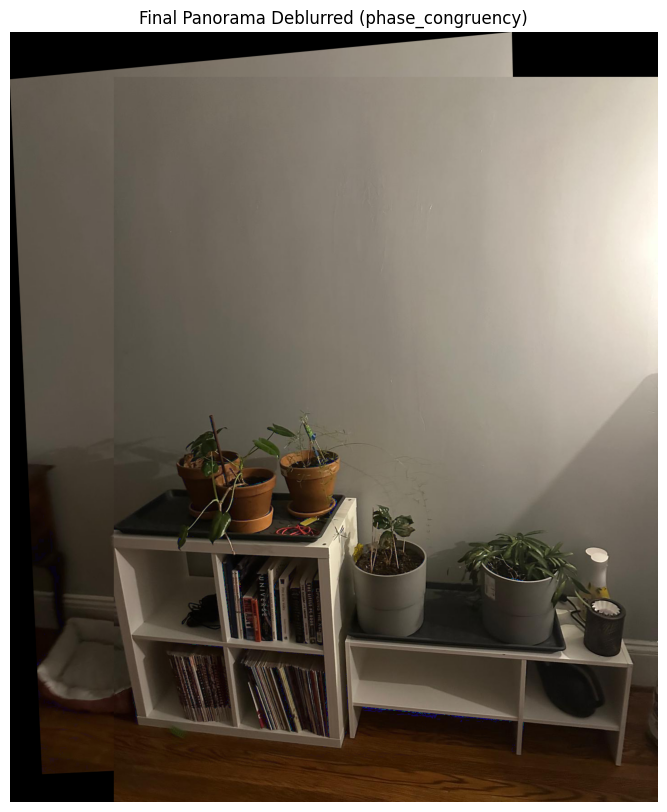

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import io

uploaded = ["set_4/i1.jpeg", "set_4/i2.jpeg", "set_4/i3.jpeg", "set_4/i4.jpeg", "set_4/i5.jpeg", "set_4/i6.jpeg"]
image_paths = natsorted(list(uploaded))
images = [cv2.imread(p, cv2.IMREAD_COLOR)
          for p in image_paths]
names = [p.split('.')[0] for p in image_paths]

print("Images uploaded and loaded in order:", names)
METHOD = "phase_congruency"   #other options (sift, rootsift, lp_sift, sift_daisy, sift_phog, phase_congruency)

from featurealgos.unified_features import (
    extract_rootsift_features,
    extract_lp_sift_features,
    extract_sift_daisy_features,
    extract_sift_phog_features,
    extract_phase_congruency_sift_features
)

def extract_method(img_gray, method):
    m = method.lower()
    if m == "sift":
        sift = cv2.SIFT_create()
        return sift.detectAndCompute(img_gray, None)
    elif m == "rootsift":
        return extract_rootsift_features(img_gray)
    elif m == "lp_sift":
        return extract_lp_sift_features(img_gray)
    elif m == "sift_daisy":
        return extract_sift_daisy_features(img_gray)
    elif m == "sift_phog":
        return extract_sift_phog_features(img_gray)
    elif m == "phase_congruency":
        return extract_phase_congruency_sift_features(img_gray)
    else:
        raise ValueError(f"Unknown method: {method}")

def match_descriptors(desc1, desc2, ratio=0.75):
    if desc1 is None or desc2 is None:
        return []
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=60)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    knn = matcher.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in knn:
        if m.distance < ratio * n.distance:
            good.append((m.queryIdx, m.trainIdx, m.distance))

    return good

# homogrpahy
def matches_to_points(kp1, kp2, matches):
    pts = []
    for qIdx, tIdx, _ in matches:
        pts.append([
            kp1[qIdx].pt[0], kp1[qIdx].pt[1],
            kp2[tIdx].pt[0], kp2[tIdx].pt[1]
        ])
    return np.array(pts, dtype=np.float64)

def ransac_homography(kp1, kp2, matches, threshold=4.0):
    if len(matches) < 4:
        return None
    pts = matches_to_points(kp1, kp2, matches)
    H, mask = cv2.findHomography(
        pts[:, 0:2], pts[:, 2:4],
        cv2.RANSAC, threshold
    )
    return H

def warp_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners1 = np.float32([[0,0],[w1,0],[w1,h1],[0,h1]]).reshape(-1,1,2)
    corners2 = np.float32([[0,0],[w2,0],[w2,h2],[0,h2]]).reshape(-1,1,2)
    warped_corners1 = cv2.perspectiveTransform(corners1, H)
    all_corners = np.concatenate((warped_corners1, corners2), axis=0)
    x_min, y_min = np.int32(all_corners.min(axis=0).ravel())
    x_max, y_max = np.int32(all_corners.max(axis=0).ravel())
    trans = np.array([[1,0,-x_min],[0,1,-y_min],[0,0,1]], dtype=np.float64)
    size = (x_max - x_min, y_max - y_min)
    result1 = cv2.warpPerspective(img1, trans @ H, size)
    result2 = cv2.warpPerspective(img2, trans, size)
    mask = (result2 > 0)
    result1[mask] = result2[mask]
    return result1

panorama = images[0]
gray = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
kp_pano, desc_pano = extract_method(gray, METHOD)

for i in range(1, len(images)):
    img_next = images[i]
    gray_next = cv2.cvtColor(img_next, cv2.COLOR_BGR2GRAY)
    kp_next, desc_next = extract_method(gray_next, METHOD)
    matches = match_descriptors(desc_pano, desc_next)
    print(f"Matches {names[i-1]} <-> {names[i]}: {len(matches)}")
    H = ransac_homography(kp_pano, kp_next, matches)
    if H is None:
        print(f"Skipping {names[i]}, not enough matches")
        continue
    panorama = warp_images(panorama, img_next, H)
    gray_pan = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    kp_pano, desc_pano = extract_method(gray_pan, METHOD)

panorama_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(panorama_rgb)
plt.axis('off')
plt.title(f"Final Panorama Deblurred ({METHOD})")
plt.show()


In [3]:
import os
import shutil
import cv2
import numpy as np

BLURRED_FOLDER = "set_4_blurred/"
DEBLURRED_FOLDER = "set_4/"

os.makedirs(BLURRED_FOLDER, exist_ok=True)
os.makedirs(DEBLURRED_FOLDER, exist_ok=True)

def load_images_from_folder(folder, exts={"jpg","png","jpeg","bmp","tiff"}):
    imgs = []
    names = []
    for f in sorted(os.listdir(folder)):
        if f.split(".")[-1].lower() in exts:
            img = cv2.imread(os.path.join(folder, f))
            if img is not None:
                imgs.append(img)
                names.append(f)
    return imgs, names

# Try loading images
blur_imgs, blur_names = load_images_from_folder(BLURRED_FOLDER)
deblur_imgs, deblur_names = load_images_from_folder(DEBLURRED_FOLDER)

# If folders are empty → prompt upload
if len(blur_imgs) == 0:
    print("📥 Please upload BLURRED images:")
    uploaded = files.upload()
    for name, data in uploaded.items():
        with open(os.path.join(BLURRED_FOLDER, name), "wb") as f:
            f.write(data)
    blur_imgs, blur_names = load_images_from_folder(BLURRED_FOLDER)
    print(f"Uploaded {len(blur_imgs)} blurred images.")

if len(deblur_imgs) == 0:
    print("📥 Please upload DEBLURRED images:")
    uploaded = files.upload()
    for name, data in uploaded.items():
        with open(os.path.join(DEBLURRED_FOLDER, name), "wb") as f:
            f.write(data)
    deblur_imgs, deblur_names = load_images_from_folder(DEBLURRED_FOLDER)
    print(f"Uploaded {len(deblur_imgs)} deblurred images.")

# Final check
if len(blur_imgs) == 0 or len(deblur_imgs) == 0:
    raise RuntimeError("❌ No images uploaded. Please try again.")

print("✔️ Images loaded successfully:")
print(f"   Blurred:   {len(blur_imgs)} images")
print(f"   Deblurred: {len(deblur_imgs)} images")


✔️ Images loaded successfully:
   Blurred:   6 images
   Deblurred: 6 images


ONNX SuperPoint model instantiated.

=== Processing method: sift ===
initial features: 0 -> 48
  stitching image 1 ...
    raw matches: 10
    updated panorama features: 286
  stitching image 2 ...
    raw matches: 18
    updated panorama features: 181
  stitching image 3 ...
    raw matches: 45
    updated panorama features: 297
  stitching image 4 ...
    raw matches: 14
    updated panorama features: 318
  stitching image 5 ...
    raw matches: 56
    updated panorama features: 350
initial features: 0 -> 229
  stitching image 1 ...
    raw matches: 40
    updated panorama features: 380
  stitching image 2 ...
    raw matches: 27
    updated panorama features: 231
  stitching image 3 ...
    raw matches: 53
    updated panorama features: 699
  stitching image 4 ...
    raw matches: 38
    updated panorama features: 577
  stitching image 5 ...
    raw matches: 69
    updated panorama features: 900

=== Processing method: rootsift ===
initial features: 0 -> 48
  stitching image 1 ...
 

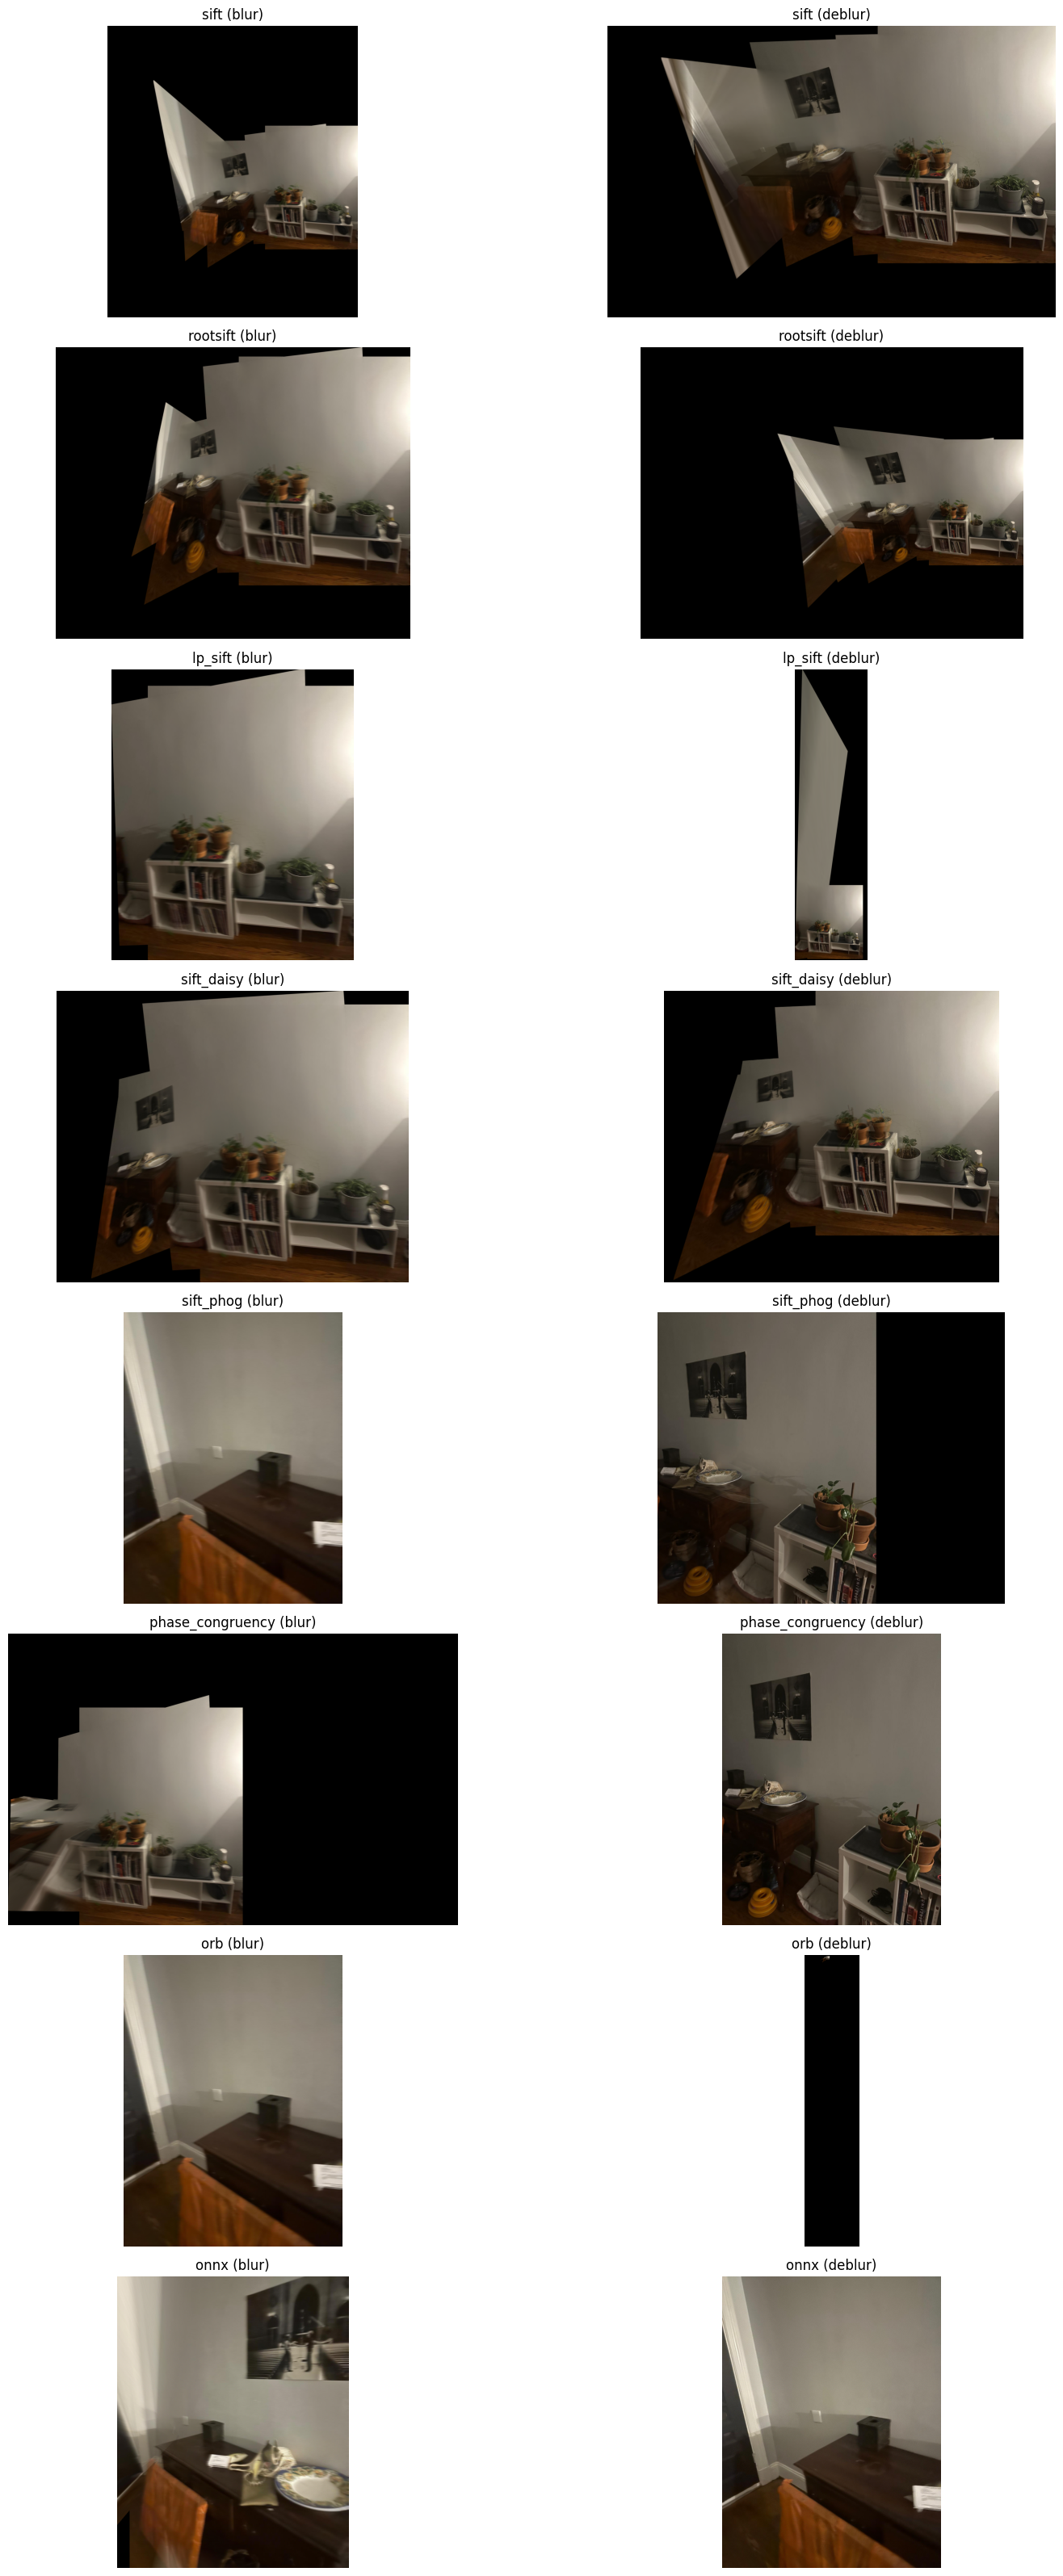

Comparison figure saved to: panoramas_comp/comparison.png


In [4]:
# Full: stitch blurred vs deblurred sets for 8 extractors from featurealgos and plot side-by-side
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from natsort import natsorted
import traceback

# Make sure featurealgos is importable (adjust if needed)
# sys.path.append('/content')  # uncomment if you uploaded a top-level featurealgos directory under /content

# Import unified feature functions from your package
from featurealgos.unified_features import (
    extract_rootsift_features,
    extract_lp_sift_features,
    extract_sift_daisy_features,
    extract_sift_phog_features,
    extract_phase_congruency_sift_features
)
# Import SuperPoint ONNX wrapper (as exposed in featurealgos)
from featurealgos.infer_onnx import SuperPointONNX

# ---------- SETTINGS ----------
BLURRED_FOLDER   = "set_4_blurred"    # folder with blurred image set
DEBLURRED_FOLDER = "set_4"  # folder with deblurred image set
METHODS = [
    "sift",
    "rootsift",
    "lp_sift",
    "sift_daisy",
    "sift_phog",
    "phase_congruency",
    "orb",
    "onnx"   # superpoint ONNX from featurealgos.infer_onnx.SuperPointONNX
]
# scale to speed things up (set to 1.0 to keep full resolution)
RESIZE_SCALE = 0.6

RATIO = 0.75            # Lowe ratio for matches
RANSAC_THRESH = 4.0     # RANSAC reprojection threshold
DIST_BLEND = True       # use distance-transform feather blending (recommended)
# ------------------------------

os.makedirs("panoramas_comp", exist_ok=True)

# Helper: load images in natural order
def load_image_list(folder, scale=1.0):
    paths = natsorted([p for p in glob(os.path.join(folder, "*")) if os.path.splitext(p)[1].lower() in ('.jpg','.jpeg','.png','.bmp','.tif','.tiff')])
    imgs = []
    names = []
    for p in paths:
        im = cv2.imread(p, cv2.IMREAD_COLOR)
        if im is None:
            print("Warning: couldn't read", p)
            continue
        if scale != 1.0:
            h,w = im.shape[:2]
            im = cv2.resize(im, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
        imgs.append(im)
        names.append(os.path.basename(p))
    return imgs, names

# Descriptor matching (returns list of tuples (queryIdx, trainIdx, distance))
def match_descriptors(desc1, desc2, ratio=RATIO):
    if desc1 is None or desc2 is None:
        return []
    # decide FLANN params depending on descriptor dtype
    # assume float descriptors for SIFT variants and SuperPoint; ORB uses binary
    if desc1.dtype == np.float32 or desc1.dtype == np.float64:
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
    else:
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    knn = matcher.knnMatch(desc1, desc2, k=2)
    good = []
    for a in knn:
        if len(a) != 2:
            continue
        m, n = a
        if m.distance < ratio * n.distance:
            good.append((m.queryIdx, m.trainIdx, m.distance))
    return good

# Convert tuple matches -> point array for homography
def matches_to_points(kp1, kp2, matches):
    pts = []
    for qIdx, tIdx, _ in matches:
        pts.append([kp1[qIdx].pt[0], kp1[qIdx].pt[1], kp2[tIdx].pt[0], kp2[tIdx].pt[1]])
    return np.array(pts, dtype=np.float64)

def compute_homography_from_matches(kp1, kp2, matches, thresh=RANSAC_THRESH):
    if len(matches) < 4:
        return None
    pts = matches_to_points(kp1, kp2, matches)
    H, mask = cv2.findHomography(pts[:,0:2], pts[:,2:4], cv2.RANSAC, thresh)
    return H

# Blending: distance transform feather blending (fast & smooth)
def warp_and_blend(img1, img2, H):
    # warp img1 into canvas defined by H and img2
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    corners1 = np.float32([[0,0],[w1,0],[w1,h1],[0,h1]]).reshape(-1,1,2)
    corners2 = np.float32([[0,0],[w2,0],[w2,h2],[0,h2]]).reshape(-1,1,2)
    warped_corners1 = cv2.perspectiveTransform(corners1, H)
    all_corners = np.concatenate((warped_corners1, corners2), axis=0)
    x_min, y_min = np.int32(all_corners.min(axis=0).ravel())
    x_max, y_max = np.int32(all_corners.max(axis=0).ravel())
    trans = np.array([[1,0,-x_min],[0,1,-y_min],[0,0,1]], dtype=np.float64)
    size = (x_max - x_min, y_max - y_min)
    warp1 = cv2.warpPerspective(img1, trans @ H, size)
    warp2 = cv2.warpPerspective(img2, trans, size)
    if DIST_BLEND:
        # masks
        m1 = np.any(warp1 != 0, axis=2).astype(np.uint8)
        m2 = np.any(warp2 != 0, axis=2).astype(np.uint8)
        # distance transforms
        d1 = cv2.distanceTransform((m1==1).astype(np.uint8), cv2.DIST_L2, 5).astype(np.float32)
        d2 = cv2.distanceTransform((m2==1).astype(np.uint8), cv2.DIST_L2, 5).astype(np.float32)
        denom = (d1 + d2 + 1e-9)
        w1 = (d1 / denom)[:,:,None]
        w2 = (d2 / denom)[:,:,None]
        blended = (warp1.astype(np.float32) * w1 + warp2.astype(np.float32) * w2)
        blended = np.clip(blended, 0, 255).astype(np.uint8)
        return blended
    else:
        # simple overlay
        mask = (warp2>0)
        warp1[mask] = warp2[mask]
        return warp1

# extract_method wrapper that selects proper extractor from featurealgos or OpenCV
def extract_method_from_featurealgos(img_color, method, onnx_model=None):
    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY) if img_color.ndim==3 else img_color
    m = method.lower()
    if m == "sift":
        sift = cv2.SIFT_create()
        kps, desc = sift.detectAndCompute(gray, None)
        return kps, (desc.astype(np.float32) if desc is not None else None)
    elif m == "rootsift":
        return extract_rootsift_features(gray)
    elif m == "lp_sift":
        return extract_lp_sift_features(gray)
    elif m == "sift_daisy":
        return extract_sift_daisy_features(gray)
    elif m == "sift_phog":
        return extract_sift_phog_features(gray)
    elif m == "phase_congruency":
        return extract_phase_congruency_sift_features(gray)
    elif m == "orb":
        orb = cv2.ORB_create(nfeatures=3000)
        kps, desc = orb.detectAndCompute(gray, None)
        return kps, (desc if desc is None else desc.astype(np.uint8))
    elif m == "onnx":
        if onnx_model is None:
            raise RuntimeError("ONNX model instance required for ONNX extractor")
        # SuperPointONNX.detect returns (keypoints, descriptors) in your package convention
        kps, desc = onnx_model.detect(gray)
        # ensure dtype float32
        return kps, (desc.astype(np.float32) if desc is not None else None)
    else:
        raise ValueError("Unknown method: " + method)

# Stitch a list of images sequentially, updating features on the panorama after each step
def stitch_sequence_with_updates(images, method, onnx_model=None, debug=False):
    if len(images) == 0:
        return None
    panorama = images[0].copy()
    kp_pano, desc_pano = extract_method_from_featurealgos(panorama, method, onnx_model=onnx_model)
    if debug:
        print(f"initial features: {0} -> {len(kp_pano) if kp_pano else 0}")
    for i in range(1, len(images)):
        if debug: print(f"  stitching image {i} ...")
        kp_next, desc_next = extract_method_from_featurealgos(images[i], method, onnx_model=onnx_model)
        matches = match_descriptors(desc_pano, desc_next)
        if debug: print(f"    raw matches: {len(matches)}")
        H = compute_homography_from_matches(kp_pano, kp_next, matches, thresh=RANSAC_THRESH)
        if H is None:
            if debug: print("    homography failed or not enough matches -> skipping image")
            continue
        # warp & blend
        try:
            panorama = warp_and_blend(panorama, images[i], H)
        except Exception as e:
            print("Warp/blend error:", e)
            traceback.print_exc()
            continue
        # recompute features on the updated panorama for next iteration
        kp_pano, desc_pano = extract_method_from_featurealgos(panorama, method, onnx_model=onnx_model)
        if debug:
            print(f"    updated panorama features: {len(kp_pano) if kp_pano else 0}")
    return panorama

# Load image sets
blur_imgs, blur_names = load_image_list(BLURRED_FOLDER, scale=RESIZE_SCALE)
deblur_imgs, deblur_names = load_image_list(DEBLURRED_FOLDER, scale=RESIZE_SCALE)

if len(blur_imgs) == 0 or len(deblur_imgs) == 0:
    raise RuntimeError("Make sure BLURRED_FOLDER and DEBLURRED_FOLDER contain images.")

# Basic check: filenames should match (or at least ordering)
if len(blur_imgs) != len(deblur_imgs):
    print("Warning: blurred and deblurred sets have different image counts.")

# Prepare ONNX model instance once (if required)
onnx_model_instance = None
# instantiate if 'onnx' in METHODS
if "onnx" in [m.lower() for m in METHODS]:
    try:
        # The SuperPointONNX class is provided by featurealgos.infer_onnx
        # instantiate with default args (the class typically loads internal model assets if configured)
        onnx_model_instance = SuperPointONNX("exported/superpoint_coco_dynamic.onnx")
        print("ONNX SuperPoint model instantiated.")
    except Exception as e:
        print("Warning: failed to instantiate SuperPointONNX:", e)
        onnx_model_instance = None

# Run through methods and produce panoramas
results = {}  # method -> (panorama_blur, panorama_deblur)
for method in METHODS:
    print("\n=== Processing method:", method, "===")
    try:
        pano_blur = stitch_sequence_with_updates(blur_imgs, method, onnx_model=onnx_model_instance, debug=True)
    except Exception as e:
        print("Error stitching blurred set for", method, ":", e)
        traceback.print_exc()
        pano_blur = None
    try:
        pano_deblur = stitch_sequence_with_updates(deblur_imgs, method, onnx_model=onnx_model_instance, debug=True)
    except Exception as e:
        print("Error stitching deblurred set for", method, ":", e)
        traceback.print_exc()
        pano_deblur = None
    results[method] = (pano_blur, pano_deblur)

# Visualization: 8 rows x 2 cols
n_methods = len(METHODS)
fig_h = 4 * n_methods
fig, axes = plt.subplots(n_methods, 2, figsize=(18, 4 * n_methods))
if n_methods == 1:
    axes = np.expand_dims(axes, 0)

for r, method in enumerate(METHODS):
    pano_b, pano_d = results[method]
    # Left: blurred panorama
    ax = axes[r, 0]
    if pano_b is None:
        ax.text(0.5, 0.5, f"No panorama (blur) for {method}", ha='center', va='center')
        ax.set_axis_off()
    else:
        try:
            ax.imshow(cv2.cvtColor(pano_b, cv2.COLOR_BGR2RGB))
            ax.set_title(f"{method} (blur)")
            ax.axis('off')
        except Exception as e:
            ax.text(0.5,0.5,f"Render error: {e}",ha='center',va='center')
            ax.set_axis_off()

    # Right: deblurred panorama
    ax = axes[r, 1]
    if pano_d is None:
        ax.text(0.5, 0.5, f"No panorama (deblur) for {method}", ha='center', va='center')
        ax.set_axis_off()
    else:
        try:
            ax.imshow(cv2.cvtColor(pano_d, cv2.COLOR_BGR2RGB))
            ax.set_title(f"{method} (deblur)")
            ax.axis('off')
        except Exception as e:
            ax.text(0.5,0.5,f"Render error: {e}",ha='center',va='center')
            ax.set_axis_off()

plt.tight_layout()
plt.show()

# Optionally save the figure
outfig = "panoramas_comp/comparison.png"
fig.savefig(outfig, dpi=200)
print("Comparison figure saved to:", outfig)


Loading images...
Stitching with method: rootsift


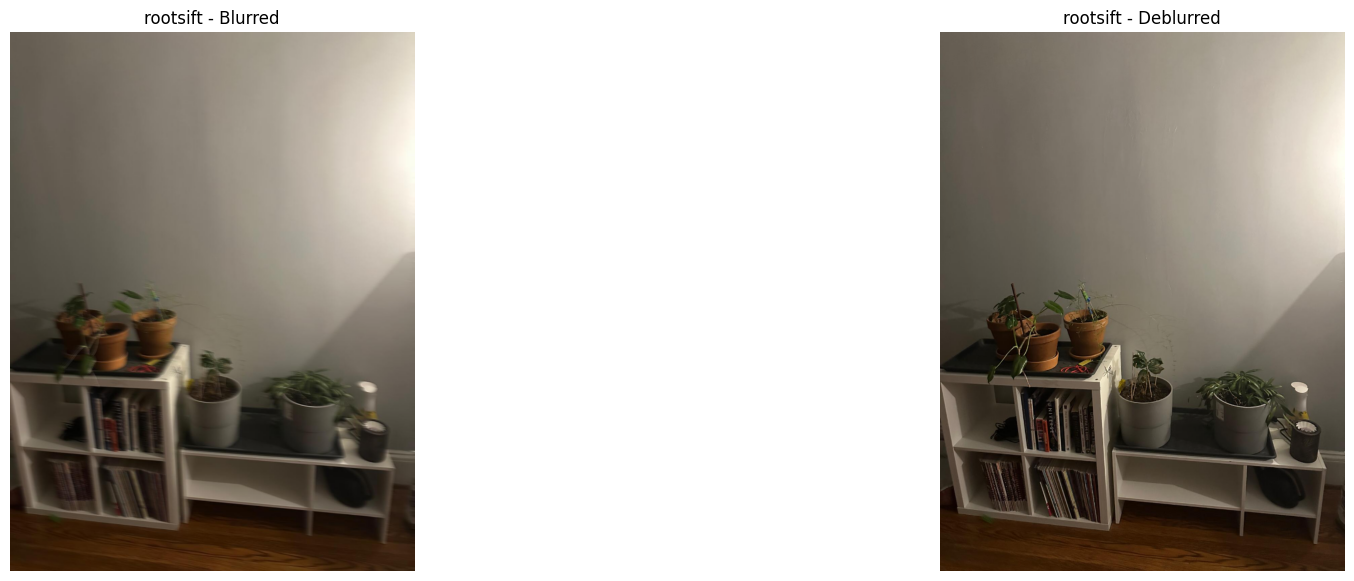

Done.


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from natsort import natsorted
import traceback

from featurealgos.unified_features import (
    extract_rootsift_features,
    extract_lp_sift_features,
    extract_sift_daisy_features,
    extract_sift_phog_features,
    extract_phase_congruency_sift_features
)
from featurealgos.infer_onnx import SuperPointONNX

# -------------------------------------------------------
# 🔧 CHANGE THIS FOR EACH RUN (8 total)
METHOD = "rootsift"
# -------------------------------------------------------

BLURRED_FOLDER   = "set_4_blurred"
DEBLURRED_FOLDER = "set_4"

RESIZE_SCALE   = 0.6
RATIO          = 0.75
RANSAC_THRESH  = 4.0
DIST_BLEND     = True


# ------------------------ LOADING ----------------------
def load_images(folder, scale=1.0):
    paths = natsorted(glob(os.path.join(folder, "*")))
    imgs = []
    for p in paths:
        im = cv2.imread(p)
        if im is None:
            print("⚠️ Could not load:", p)
            continue
        if scale != 1.0:
            h,w = im.shape[:2]
            im = cv2.resize(im, (int(w*scale), int(h*scale)), cv2.INTER_AREA)
        imgs.append(im)
    return imgs


# -------------------- MATCHING ------------------------
def match_desc(desc1, desc2, ratio=0.75):
    if desc1 is None or desc2 is None:
        return []
    # float descriptors → FLANN
    if desc1.dtype in (np.float32, np.float64):
        index_params  = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        knn = flann.knnMatch(desc1, desc2, k=2)
    else:  # binary → Hamming
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
        knn = bf.knnMatch(desc1, desc2, k=2)

    good = []
    for m,n in knn:
        if m.distance < ratio * n.distance:
            good.append((m.queryIdx, n.trainIdx))
    return good


# ------------------ HOMOGRAPHY ------------------------
def compute_H(kp1, kp2, matches):
    if len(matches) < 4:
        return None
    src = np.float32([kp1[i].pt for i,j in matches])
    dst = np.float32([kp2[j].pt for i,j in matches])
    H, _ = cv2.findHomography(src, dst, cv2.RANSAC, RANSAC_THRESH)
    return None if H is None else H.astype(np.float64)


# ------------------ FEATURE SELECTION ------------------
def extract_features(img, method, onnx_model=None):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    m = method.lower()

    if m == "sift":
        sift = cv2.SIFT_create()
        return sift.detectAndCompute(gray, None)

    if m == "rootsift":
        return extract_rootsift_features(gray)

    if m == "lp_sift":
        return extract_lp_sift_features(gray)

    if m == "sift_daisy":
        return extract_sift_daisy_features(gray)

    if m == "sift_phog":
        return extract_sift_phog_features(gray)

    if m == "phase_congruency":
        return extract_phase_congruency_sift_features(gray)

    if m == "orb":
        orb = cv2.ORB_create(nfeatures=3000)
        kps, desc = orb.detectAndCompute(gray, None)
        return kps, desc

    if m == "onnx":
        return onnx_model.detect(gray)

    raise ValueError("Unknown method:", method)


# ------------------------- WARP & BLEND -------------------
def warp_blend(img1, img2, H):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]

    c1 = np.float32([[0,0],[w1,0],[w1,h1],[0,h1]]).reshape(-1,1,2)
    c2 = np.float32([[0,0],[w2,0],[w2,h2],[0,h2]]).reshape(-1,1,2)

    w1_corners = cv2.perspectiveTransform(c1, H)
    all_pts = np.vstack((w1_corners, c2))

    x_min, y_min = np.int32(all_pts.min(axis=0).ravel())
    x_max, y_max = np.int32(all_pts.max(axis=0).ravel())

    T = np.array([[1,0,-x_min],[0,1,-y_min],[0,0,1]], dtype=np.float64)
    size = (x_max - x_min, y_max - y_min)

    warp1 = cv2.warpPerspective(img1, T @ H, size)
    warp2 = cv2.warpPerspective(img2, T, size)

    if not DIST_BLEND:
        warp1[warp2 > 0] = warp2[warp2 > 0]
        return warp1

    m1 = (warp1 > 0).any(axis=2).astype(np.uint8)
    m2 = (warp2 > 0).any(axis=2).astype(np.uint8)

    d1 = cv2.distanceTransform(m1, cv2.DIST_L2, 5)
    d2 = cv2.distanceTransform(m2, cv2.DIST_L2, 5)

    denom = d1 + d2 + 1e-9
    a1 = (d1 / denom)[..., None]
    a2 = (d2 / denom)[..., None]

    out = warp1.astype(float)*a1 + warp2.astype(float)*a2
    return out.astype(np.uint8)


# ----------------------- STITCHER --------------------------
def stitch(images, method):
    if len(images) == 0:
        return None

    onnx_model = None
    if method.lower() == "onnx":
        onnx_model = SuperPointONNX("exported/superpoint_coco_dynamic.onnx")

    pano = images[0].copy()
    kp_p, desc_p = extract_features(pano, method, onnx_model)

    for i in range(1, len(images)):
        kp_i, desc_i = extract_features(images[i], method, onnx_model)
        matches = match_desc(desc_p, desc_i)

        H = compute_H(kp_p, kp_i, matches)
        if H is None:
            print("⚠️ Not enough matches — skipping")
            continue

        pano = warp_blend(pano, images[i], H)

        kp_p, desc_p = extract_features(pano, method, onnx_model)

    return pano


# ======================= RUN ============================
print("Loading images...")
blur   = load_images(BLURRED_FOLDER,   RESIZE_SCALE)
deblur = load_images(DEBLURRED_FOLDER, RESIZE_SCALE)

print("Stitching with method:", METHOD)
pano_blur   = stitch(blur, METHOD)
pano_deblur = stitch(deblur, METHOD)


# ------------------ SHOW SIDE-BY-SIDE --------------------
plt.figure(figsize=(22,7))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(pano_blur, cv2.COLOR_BGR2RGB))
plt.title(f"{METHOD} - Blurred")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(pano_deblur, cv2.COLOR_BGR2RGB))
plt.title(f"{METHOD} - Deblurred")
plt.axis("off")

plt.show()

print("Done.")


Images loaded: ['set_4/i1', 'set_4/i2', 'set_4/i3', 'set_4/i4', 'set_4/i5', 'set_4/i6']
set_4/i1 -> set_4/i2 : 37 matches
set_4/i2 -> set_4/i3 : 24 matches
set_4/i3 -> set_4/i4 : 8 matches
Skipping, not enough matches
set_4/i4 -> set_4/i5 : 3 matches
Skipping, not enough matches
set_4/i5 -> set_4/i6 : 2 matches
Skipping, not enough matches


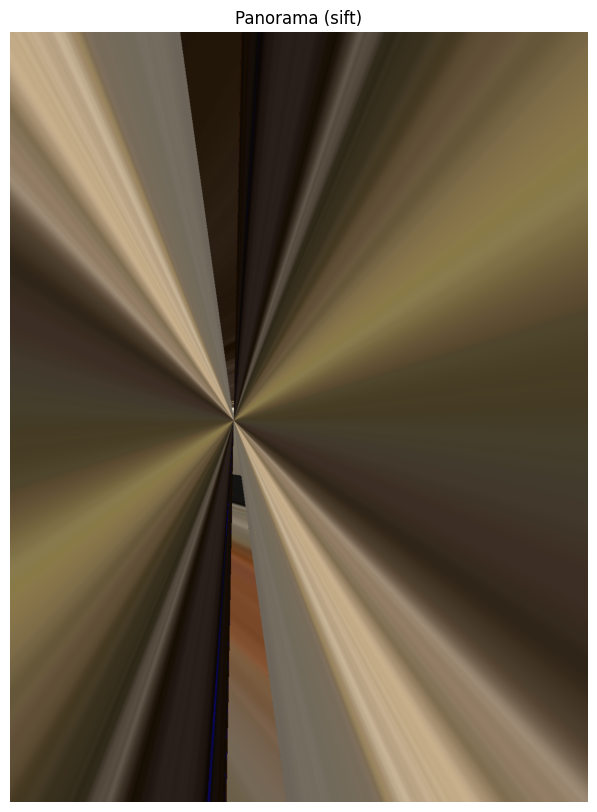

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted

# -----------------------------------------------------
# 🔧 CHANGE THIS FOR EACH RUN
METHOD = "sift"       # sift, rootsift, lp_sift, sift_daisy, sift_phog, phase_congruency
# -----------------------------------------------------

# --- Upload images (works in correct order if filenames sorted) ---
uploaded = ["set_4/i1.jpeg", "set_4/i2.jpeg", "set_4/i3.jpeg", "set_4/i4.jpeg", "set_4/i5.jpeg", "set_4/i6.jpeg"]
image_paths = natsorted(list(uploaded))
images = [cv2.imread(p, cv2.IMREAD_COLOR)
          for p in image_paths]
names = [p.split('.')[0] for p in image_paths]

print("Images loaded:", names)


# ---------------- Feature Extractors -----------------
from featurealgos.unified_features import (
    extract_rootsift_features,
    extract_lp_sift_features,
    extract_sift_daisy_features,
    extract_sift_phog_features,
    extract_phase_congruency_sift_features
)

def extract_method(img_gray, method):
    m = method.lower()

    if m == "sift":
        sift = cv2.SIFT_create()
        return sift.detectAndCompute(img_gray, None)

    elif m == "rootsift":
        return extract_rootsift_features(img_gray)

    elif m == "lp_sift":
        return extract_lp_sift_features(img_gray)

    elif m == "sift_daisy":
        return extract_sift_daisy_features(img_gray)

    elif m == "sift_phog":
        return extract_sift_phog_features(img_gray)

    elif m == "phase_congruency":
        return extract_phase_congruency_sift_features(img_gray)

    else:
        raise ValueError("Unknown method:", method)


# ---------------- Matching -----------------
def match_descriptors(desc1, desc2, ratio=0.75):
    if desc1 is None or desc2 is None:
        return []

    # Using FLANN for float descriptors
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=60)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)

    knn = matcher.knnMatch(desc1, desc2, k=2)
    good = []

    for m, n in knn:
        if m.distance < ratio * n.distance:
            good.append((m.queryIdx, n.trainIdx, m.distance))

    return good


# ---------------- Homography -----------------
def matches_to_points(kp1, kp2, matches):
    pts = [
        [kp1[q].pt[0], kp1[q].pt[1], kp2[t].pt[0], kp2[t].pt[1]]
        for q, t, _ in matches
    ]
    return np.array(pts, dtype=np.float64)

def ransac_homography(kp1, kp2, matches, thresh=4.0):
    if len(matches) < 4:
        return None
    pts = matches_to_points(kp1, kp2, matches)
    H, _ = cv2.findHomography(pts[:,0:2], pts[:,2:4], cv2.RANSAC, thresh)
    return H


# ---------------- Warping + Simple Overlay -----------------
def warp_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    c1 = np.float32([[0,0],[w1,0],[w1,h1],[0,h1]]).reshape(-1,1,2)
    c2 = np.float32([[0,0],[w2,0],[w2,h2],[0,h2]]).reshape(-1,1,2)

    warped_c1 = cv2.perspectiveTransform(c1, H)
    all_corners = np.concatenate((warped_c1, c2), axis=0)

    x_min, y_min = np.int32(all_corners.min(axis=0).ravel())
    x_max, y_max = np.int32(all_corners.max(axis=0).ravel())

    T = np.array([[1,0,-x_min], [0,1,-y_min], [0,0,1]], dtype=np.float64)
    size = (x_max - x_min, y_max - y_min)

    base = cv2.warpPerspective(img1, T, size)
    warped = cv2.warpPerspective(img2, T @ H, size)

    mask = warped > 0
    base[mask] = warped[mask]
    return base


# ---------------- Stitching -----------------
panorama = images[0]
gray_pan = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
kp_pano, desc_pano = extract_method(gray_pan, METHOD)

for i in range(1, len(images)):
    img_next = images[i]
    gray_next = cv2.cvtColor(img_next, cv2.COLOR_BGR2GRAY)

    kp_next, desc_next = extract_method(gray_next, METHOD)
    matches = match_descriptors(desc_pano, desc_next)

    print(f"{names[i-1]} -> {names[i]} : {len(matches)} matches")

    H = ransac_homography(kp_pano, kp_next, matches)

    if H is None:
        print("Skipping, not enough matches")
        continue

    # Warp and update the panorama
    panorama = warp_images(panorama, img_next, H)

    # Update features on new panorama
    gray_pan = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    kp_pano, desc_pano = extract_method(gray_pan, METHOD)


# ---------------- Display -----------------
panorama_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(panorama_rgb)
plt.axis('off')
plt.title(f"Panorama ({METHOD})")
plt.show()
